# Tarea 3 - MAN3160



**Profesor**: Denis Parra

**Ayudante**: Álvaro Labarca.


En esta tarea, se utilizará la biblioteca DeepCTR-Torch para generar un sistema recomendador que utiliza información de contenido y contexto.

## Descarga del dataset

Nuevamente, se utilizará el dataset MovieLens-100k para esta tarea.

In [1]:
!pip install wget
!pip install zipfile36
!pip3 install implicit --upgrade
!python -m wget http://files.grouplens.org/datasets/movielens/ml-100k.zip
!pip install deepctr-torch
!pip install tensorflow

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=caea36869c5c77046cd8489a5dc1b8570c8998dd85d3ea01f987b807fa93afb1
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 21.6 MB/s eta 0:00:00

Saved under ml-100k.zip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 2.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_

In [2]:
import zipfile
with zipfile.ZipFile("ml-100k.zip", 'r') as zip_ref:
    zip_ref.extractall(".")

In [3]:
# Pueden importar más librerías si es necesario

import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import numpy as np
import scipy.sparse as sparse
import time
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score
import implicit
from deepctr_torch.inputs import SparseFeat, VarLenSparseFeat, get_feature_names
from deepctr_torch.models import DeepFM

In [4]:
def split(x):
    key_ans = x.split('|')
    for key in key_ans:
        if key not in key2index:
            # Notice : input value 0 is a special "padding",so we do not use 0 to encode valid feature for sequence input
            key2index[key] = len(key2index) + 1
    return list(map(lambda x: key2index[x], key_ans))

In [5]:
dir_train = 'ml-100k'

# Generamos los títulos de las columnas del archivo items.

columns = ['itemid', 'title', 'release_date', 'video_release_date', \
           'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', \
           'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', \
           'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', \
           'Thriller', 'War', 'Western']

In [6]:
df = pd.read_csv(f'{dir_train}/u.data',
                         sep='\t',
                         names=['userid', 'itemid', 'rating', 'timestamp'],
                         header=None)

In [7]:
df_items = pd.read_csv(f'{dir_train}/u.item',
                        sep='|',
                        index_col=0,
                        names = columns,
                        header=None,
                        encoding='latin-1')

In [8]:
columns_user = ['userid', 'age', 'gender', 'occupation', 'zip_code']

In [9]:
df_users = pd.read_csv(f'{dir_train}/u.user',
                        sep='|',
                        index_col=0,
                        names = columns_user,
                        header=None,
                        encoding='latin-1')

df_users = df_users.reset_index()
df_items = df_items.reset_index()

In [10]:
df_total = pd.merge(df, df_users, on='userid')
df_total = pd.merge(df_total, df_items, on='itemid')

In [11]:
def combine_genres(row):
    genres = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', \
              'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
    return '|'.join([col for col, val in row.items() if val == 1 and col in genres])

In [12]:
df_total['genres'] = df_total.apply(combine_genres, axis=1)

In [13]:
genres = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', \
              'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
df_total = df_total.drop(genres, axis=1)

In [14]:
df_total.sort_values(by='timestamp').head(10)

,userid,itemid,rating,timestamp,age,gender,occupation,zip_code,title,release_date,video_release_date,IMDb_URL,unknown,genres
43056,259,255,4,874724710,21,M,student,48823,My Best Friend's Wedding (1997),20-Jun-1997,NaN,http://us.imdb.com/M/title-exact?My+Best+Frien...,0,Comedy|Romance
1899,259,286,4,874724727,21,M,student,48823,"English Patient, The (1996)",15-Nov-1996,NaN,http://us.imdb.com/M/title-exact?English%20Pat...,0,Drama|Romance|War
17880,259,298,4,874724754,21,M,student,48823,Face/Off (1997),27-Jun-1997,NaN,http://us.imdb.com/M/title-exact?Face/Off+(1997),0,Action|Sci-Fi|Thriller
58719,259,185,4,874724781,21,M,student,48823,Psycho (1960),01-Jan-1960,NaN,http://us.imdb.com/M/title-exact?Psycho%20(1960),0,Horror|Romance|Thriller
5563,259,173,4,874724843,21,M,student,48823,"Princess Bride, The (1987)",01-Jan-1987,NaN,http://us.imdb.com/M/title-exact?Princess%20Br...,0,Action|Adventure|Comedy|Romance
48244,259,772,4,874724882,21,M,student,48823,Kids (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Kids%20(1995),0,Drama
3747,259,108,4,874724882,21,M,student,48823,Kids in the Hall: Brain Candy (1996),12-Apr-1996,NaN,http://us.imdb.com/M/title-exact?Kids%20in%20t...,0,Comedy
10683,259,288,3,874724905,21,M,student,48823,Scream (1996),20-Dec-1996,NaN,http://us.imdb.com/M/title-exact?Scream%20(1996),0,Horror|Thriller
88373,259,928,4,874724937,21,M,student,48823,"Craft, The (1996)",26-Apr-1996,NaN,"http://us.imdb.com/M/title-exact?Craft,%20The%...",0,Drama|Horror
10132,259,117,4,874724988,21,M,student,48823,"Rock, The (1996)",07-Jun-1996,NaN,"http://us.imdb.com/M/title-exact?Rock,%20The%2...",0,Action|Adventure|Thriller


# Actividades

### Actividad 1: Análisis de características de contenido.

En el tutorial de DeepCTR-torch, se dio un ejemplo del entrenamiento de un modelo con DeepCTR-torch que combinó data de contexto y de contenido. En esta tarea, se realizará un procedimiento similar. Se les proporcionó el código para generar el dataframe df_total, el cual contiene todo los metadatos de contenido para cada interacción. Esta primera actividad se tratará de seleccionar los datos de contenido que usarán y realicen un análisis de ello. Lo que deben hacer es:

* Seleccionar las columnas de contenido que creen que proporcionan información que puede ser aprovechada por un algoritmo recomendador. Deben elegir al menos dos características del usuario y dos características de los ítems. Se debe indicar explícitamente la información seleccionada y entregar una breve justificación de por qué esta información podría ser útil al realizar una recomendación.
* Elija dos de las características que seleccionó en el paso anterior (pueden ser de usuario y/o ítem) y grafique sus distribuciones. Por ejemplo, si eligió la edad, grafique un histograma con la distribución de edad de los usuarios. Comente acerca de esta distribución. Calcule y entregue además el promedio y desviación estándar de esta distribución si es una característica no discreta o bien, el valor más popular y menos popular si es una característica discreta.

#### Respuesta:

Ingrese su respuesta continuación. Recuerde terminar su respuesta con una celda de texto con sus conclusiones y respuestas.

## Características de usuario:
**Género**: Seleccionamos la columna de género como una característica relevante del usuario debido a las diferencias significativas en los gustos y preferencias entre hombres y mujeres. Al considerar el género del usuario, el algoritmo puede ofrecer recomendaciones más precisas y personalizadas, adaptadas a sus intereses específicos.
**Edad**: Optamos por incluir la columna de edad del usuario debido a la influencia que tiene en sus preferencias de contenido. Las personas de diferentes edades tienden a tener gustos distintos en películas y programas de televisión. Por ejemplo, un niño puede preferir contenido animado, mientras que un adulto puede inclinarse hacia dramas o documentales. Al tener en cuenta la edad del usuario, el algoritmo puede sugerir contenido más relevante y adecuado para su grupo demográfico.
## Características del ítem:
**Género y año de lanzamiento**: Elegimos el género y el año de lanzamiento como características importantes del ítem debido a su impacto en las preferencias de los usuarios. El género proporciona información sobre el tema y el tono general de la película o programa, lo que ayuda al algoritmo a recomendar contenido que se alinee con los intereses del usuario. Por otro lado, el año de lanzamiento puede indicar la relevancia y la frescura del contenido para el usuario. Las películas más recientes pueden reflejar tendencias y estilos contemporáneos, mientras que las más antiguas pueden tener un atractivo nostálgico o histórico. Consideramos estas características cruciales para ofrecer recomendaciones precisas y atractivas que satisfagan las preferencias individuales de cada usuario

Características **item**:

Género y año de lanzamiento. La columna género definitivamente nos da una base de que tratará la película y el año de lanzamiento también aporta bastante, creo que las peliculas recientes con respecto a las más antiguas son para gustos diferentes. En el caso de género de película, también podría vincularse con el contexto, respecto al horario o día de la semana. Por ejemplo, si es una película de terror, podría influir en el rating según la hora que se vió la película. En el caso del año de lanzamiento, si la película es muy antigua con respecto a la fecha del rating, quizás la calificación sería distinta a que el año de lanzamiento y año del rating sean cercanos.

<Axes: xlabel='age', ylabel='Count'>

'promedio Age usuario: 32.96985'

'dev std Age usuario: 11.562623314805304'

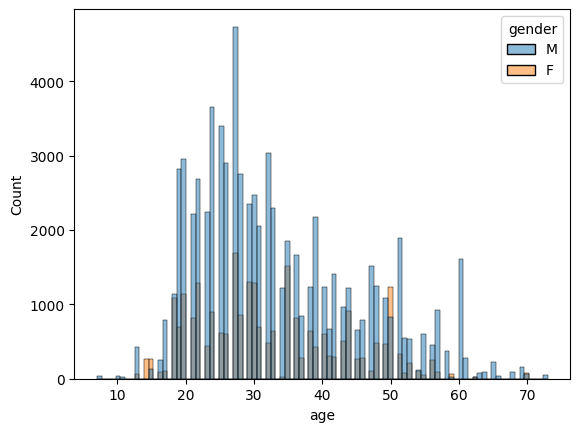

In [15]:
# Caracteristicas de usuario, genero y edad
import seaborn as sns

display(sns.histplot(data=df_total, x='age', hue='gender'))

# Caracteristicas de item, fecha de estreno y genero
display(f"promedio Age usuario: {df_total['age'].mean()}")
display(f"dev std Age usuario: {df_total['age'].std()}")

La distribución de la edad de los usuarios muestra que la mayoría de los datos se concentran entre los 18 y los 55 años, lo que sugiere una amplia gama de edades representadas en la muestra. El promedio de edad de los usuarios es de 32.9 años, lo que indica que el grupo de usuarios tiende a ser relativamente joven en general. La desviación estándar de 11.5 años sugiere que la dispersión de las edades alrededor del promedio es moderada. Además, es importante destacar que la mayoría de los usuarios son hombres, lo que puede influir en las preferencias de contenido y en las recomendaciones generadas por el algoritmo.

<Axes: xlabel='release_year', ylabel='Count'>

'Promedio año de lanzamiento: 1987.9562160594453'

'Dev std año de lanzamiento: 14.155522633275842'

'El género más visto: Drama'

'El género menos visto: Documentary'

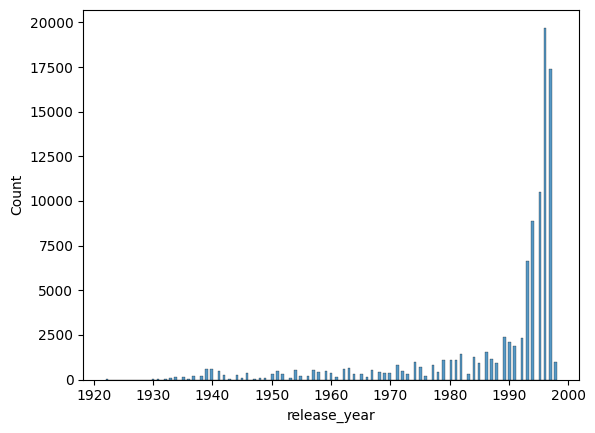

In [16]:
df_total['release_datetime'] = pd.to_datetime(df_total['release_date'])
df_total['release_year'] = df_total['release_datetime'].dt.year
display(sns.histplot(data=df_total, x='release_year'))
display(f"Promedio año de lanzamiento: {df_total['release_year'].mean()}")
display(f"Dev std año de lanzamiento: {df_total['release_year'].std()}")

# Generos más vistos
genres_df = df_total['genres'].str.split('|', expand=True)
stacked_genres = genres_df.stack()
print('')
display(f"El género más visto: {stacked_genres.value_counts().index[0]}")
display(f"El género menos visto: {stacked_genres.value_counts().index[-2]}")

El promedio del año de lanzamiento de las películas en la muestra es 1987, lo que indica que la mayoría de las películas tienen una antigüedad considerable. La desviación estándar de 14 años sugiere que hay una variabilidad significativa en los años de lanzamiento, lo que puede reflejar una amplia diversidad de géneros y estilos cinematográficos. En cuanto a los géneros de las películas, es interesante observar que los géneros más vistos son Drama y Comedia, con un alto número de interacciones, mientras que los documentales tienen menos interacciones, lo que sugiere que pueden ser menos populares entre los usuarios.

### Actividad 2: Generación de característica de contexto.

En el ejemplo del tutorial, se generó a partir del timestamp una característica discreta que indicaba si una calificación fue ingresada en la mañana, tarde o noche.

* A partir del timestamp (ya que este es la única característica contextual del dataset), capture otra característica contextual que pueda ser utilizada en el entrenamiento (que no sea una división de mañana/tarde/noche). Justifique su elección explicando por qué se podría aprovechar esa información de contexto para generar mejores recomendaciones. Puede asumir que el timestamp indica la hora en que fue vista la película (en lugar de la hora en la que fue ingresada la calificación) y que todos los usuarios están en la zona horaria entregada por la conversión a dataframe mostrada por la ayudantía.
* Genere una hipótesis de cómo podría influir la variable contextual en la recomendación. (Por ejemplo, una hipótesis podría ser que en la noche, se deberían recomendar una mayor cantidad de películas de terror).

#### Respuesta:

Ingrese su respuesta continuación. Recuerde terminar su respuesta con una celda de texto con sus conclusiones y respuestas.

In [17]:
# Creamos la variable `weekend` para definir como contexto si vemos la película un fin de semana o no
df_total['datetime'] = pd.to_datetime(df_total['timestamp'], unit='s')  # Convert the column to datetime format if it's not
df_total['Weekday'] = df_total['datetime'].dt.weekday
def definir_fin_semena(day):
    if day >= 4:
        return True
    return False
df_total['weekend'] = df_total['Weekday'].apply(definir_fin_semena)
df_total[['userid', 'itemid', 'rating', 'weekend']]

,userid,itemid,rating,weekend
0,196,242,3,False
1,305,242,5,True
2,6,242,4,True
3,234,242,4,True
4,63,242,3,False
...,...,...,...,...
99995,863,1679,3,True
99996,863,1678,1,True
99997,863,1680,2,True
99998,896,1681,3,False


Usando los fines de semana, se puede considerar como hipótesis que **la densidad de películas a recomendar en un fin de semana serán películas más antiguas**. Esto, dado que los fines de semana generalmente los adultos tienen más tiempo para ver películas, que en un día de semana. En el caso de los estudiantes, ellos probablemente ven películas en cualquier día en particular. Como los adultos tienen más edad, probablemente pueden preferir películas de mayor data, o bien, los estudiantes pueden preferir películas más nuevas.

### Actividad 3: Entrenamiento Modelos.

Entrene modelos de recomendación utilizando la librería DeepCTR-torch.

* El primer modelo debe contener solo la información de las interacciones, es decir, usuario, item y rating.
* Al segundo modelo se le deben agregar las caracterísitcas de contenido.
* El tercer modelo debe tener la característica contextual.

Recuerde que antes de entrenar, se debe generar la división train-test del dataset.

Recuerde variar los hiperparámetros para obtener mejores resultados y entrene por al menos 12 épocas cada modelo.

#### Respuesta:

Ingrese su respuesta continuación. Recuerde terminar su respuesta con una celda de texto con sus conclusiones y respuestas.

In [18]:
# Preparación de los datos

# Convierta las peliculas agrupadas a un numero por cada pelicula
key2index = {}
genres_list = list(map(split, df_total['genres'].values))
genres_length = np.array(list(map(len, genres_list)))

# codifica las columnas a numeros unicos con LabelEncoder
sparse_features = ["userid", "itemid", "gender", "age", "release_year", "weekend"]
for feat in sparse_features:
    lbe = LabelEncoder()
    df_total[feat] = lbe.fit_transform(df_total[feat])

target = ['rating']
max_len = max(genres_length)
genres_list = pad_sequences(genres_list, maxlen=max_len, padding='post', )
# Caracteristicas de largo fijo
fixlen_feature_columns = [SparseFeat(feat, df_total[feat].nunique(), embedding_dim=4)
                        for feat in sparse_features]
# Carateristicas de largo variable
varlen_feature_columns = [VarLenSparseFeat(SparseFeat('genres', vocabulary_size=len(
        key2index) + 1, embedding_dim=4), maxlen=max_len, combiner='mean')]
# Union de carácteristicas parte lineal
linear_feature_columns = fixlen_feature_columns + varlen_feature_columns
# Union de carácteristicas parte dnn
dnn_feature_columns = fixlen_feature_columns + varlen_feature_columns

# Datos de train y test
train, test = train_test_split(df_total, test_size=0.25)
# Lista de indice de los datasets
train_index = train.index.tolist()
test_index = test.index.tolist()
genres_list_train = genres_list[train_index]
genres_list_test = genres_list[test_index]



In [19]:
# Lista para el modelo 1
train_model_input_1 = {name: train[name] for name in ["userid", "itemid"]}
test_model_input_1 = {name: test[name] for name in ["userid", "itemid"]}

# Lista para el modelo 2, consideramos las variables de contenido: edad persona, género persona, género película, año lanzamiento
train_model_input_2 = {name: train[name] for name in ["userid", "itemid", "gender", "age", "release_year"]}
train_model_input_2["genres"] = genres_list_train
test_model_input_2 = {name: test[name] for name in ["userid", "itemid", "gender", "age", "release_year"]}
test_model_input_2["genres"] = genres_list_test

# Lista para el modelo 3
train_model_input_3 = {name: train[name] for name in sparse_features}
train_model_input_3["genres"] = genres_list_train
test_model_input_3 = {name: test[name] for name in sparse_features}
test_model_input_3["genres"] = genres_list_test

In [20]:
linear_feature_columns

[SparseFeat(name='userid', vocabulary_size=943, embedding_dim=4, use_hash=False, dtype='int32', embedding_name='userid', group_name='default_group'),
 SparseFeat(name='itemid', vocabulary_size=1682, embedding_dim=4, use_hash=False, dtype='int32', embedding_name='itemid', group_name='default_group'),
 SparseFeat(name='gender', vocabulary_size=2, embedding_dim=4, use_hash=False, dtype='int32', embedding_name='gender', group_name='default_group'),
 SparseFeat(name='age', vocabulary_size=61, embedding_dim=4, use_hash=False, dtype='int32', embedding_name='age', group_name='default_group'),
 SparseFeat(name='release_year', vocabulary_size=72, embedding_dim=4, use_hash=False, dtype='int32', embedding_name='release_year', group_name='default_group'),
 SparseFeat(name='weekend', vocabulary_size=2, embedding_dim=4, use_hash=False, dtype='int32', embedding_name='weekend', group_name='default_group'),
 VarLenSparseFeat(sparsefeat=SparseFeat(name='genres', vocabulary_size=20, embedding_dim=4, use_h

In [21]:
dnn_feature_columns

[SparseFeat(name='userid', vocabulary_size=943, embedding_dim=4, use_hash=False, dtype='int32', embedding_name='userid', group_name='default_group'),
 SparseFeat(name='itemid', vocabulary_size=1682, embedding_dim=4, use_hash=False, dtype='int32', embedding_name='itemid', group_name='default_group'),
 SparseFeat(name='gender', vocabulary_size=2, embedding_dim=4, use_hash=False, dtype='int32', embedding_name='gender', group_name='default_group'),
 SparseFeat(name='age', vocabulary_size=61, embedding_dim=4, use_hash=False, dtype='int32', embedding_name='age', group_name='default_group'),
 SparseFeat(name='release_year', vocabulary_size=72, embedding_dim=4, use_hash=False, dtype='int32', embedding_name='release_year', group_name='default_group'),
 SparseFeat(name='weekend', vocabulary_size=2, embedding_dim=4, use_hash=False, dtype='int32', embedding_name='weekend', group_name='default_group'),
 VarLenSparseFeat(sparsefeat=SparseFeat(name='genres', vocabulary_size=20, embedding_dim=4, use_h

Probaremos con tres valores de epocas y batch size, para encontrar los hiperparámetros óptimos. Además, dejamos una semilla puesta para poder replicar resultados.

In [22]:
batch_sizes = [128, 256, 512]
epochs = [12, 20, 30]
seed = 1032

In [23]:
best_batch_size = None
best_epochs = None

Entrenamos y probamos para obtener los mejores hiperparámetros

In [24]:
import tensorflow as tf


tf.random.set_seed(seed)

device = 'cpu'
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print('cuda ready...')
    device = 'cuda:0'

min_mse = float('inf')

# Entrenamos con cada hiperparámetro el modelo más simple: interacciones de usuarios con ítems.

# Entrenamiento variando batch_size y epochs = 12
for i in range(len(batch_sizes)):

    # Seteamos los hiperparametros
    b_size = batch_sizes[i]

    linear_ft_columns = linear_feature_columns[:2]
    dnn_ft_columns = dnn_feature_columns[:2]

    # Instanciamos el modelo y lo entrenamos
    model = DeepFM(linear_ft_columns, dnn_ft_columns, task='regression', device=device)
    model.compile("adam", "mse", metrics=['mse'])
    history = model.fit(train_model_input_1, train[target].values,
                            batch_size=b_size,
                            epochs=12, # Dejamos las epochs constantes en 12
                            verbose=2,
                            validation_split=0.2)

    # Entrenamos y obtenemos el mse
    pred_ans = model.predict(test_model_input_1, b_size)

    current_mse = round(mean_squared_error(test[['rating']].values, pred_ans), 5)

    if current_mse < min_mse:
        min_mse = current_mse
        best_batch_size = b_size


min_mse = float('inf')
# Entrenamos con cada hiperparámetro el modelo más simple: interacciones de usuarios con ítems.
# Entrenamiento variando epochs y batch_size = 256
for i in range(len(epochs)):

    # Seteamos los hiperparametros
    ep = epochs[i]

    linear_ft_columns = linear_feature_columns[:2]
    dnn_ft_columns = dnn_feature_columns[:2]

    # Instanciamos el modelo y lo entrenamos
    model = DeepFM(linear_ft_columns, dnn_ft_columns, task='regression', device=device)
    model.compile("adam", "mse", metrics=['mse'])
    history = model.fit(train_model_input_1, train[target].values,
                            batch_size=256,
                            epochs=ep, # Dejamos las epochs constantes en 12
                            verbose=2,
                            validation_split=0.2)

    # Entrenamos y obtenemos el mse
    pred_ans = model.predict(test_model_input_1, b_size)

    current_mse = round(mean_squared_error(test[['rating']].values, pred_ans), 5)

    if current_mse < min_mse:
        min_mse = current_mse
        best_epochs = ep

print('Best batch_size: ', best_batch_size)
print('Best epochs: ', best_epochs)


cpu
Train on 60000 samples, validate on 15000 samples, 469 steps per epoch
Epoch 1/12
2s - loss:  1.4774 - mse:  1.4773 - val_mse:  0.9067
Epoch 2/12
2s - loss:  0.8836 - mse:  0.8836 - val_mse:  0.8865
Epoch 3/12
2s - loss:  0.8686 - mse:  0.8685 - val_mse:  0.8884
Epoch 4/12
2s - loss:  0.8646 - mse:  0.8646 - val_mse:  0.8943
Epoch 5/12
2s - loss:  0.8611 - mse:  0.8611 - val_mse:  0.8872
Epoch 6/12
4s - loss:  0.8575 - mse:  0.8575 - val_mse:  0.8949
Epoch 7/12
5s - loss:  0.8571 - mse:  0.8571 - val_mse:  0.8879
Epoch 8/12
2s - loss:  0.8545 - mse:  0.8545 - val_mse:  0.8886
Epoch 9/12
2s - loss:  0.8544 - mse:  0.8545 - val_mse:  0.8892
Epoch 10/12
2s - loss:  0.8519 - mse:  0.8518 - val_mse:  0.8975
Epoch 11/12
2s - loss:  0.8508 - mse:  0.8507 - val_mse:  0.8868
Epoch 12/12
2s - loss:  0.8493 - mse:  0.8493 - val_mse:  0.8862
cpu
Train on 60000 samples, validate on 15000 samples, 235 steps per epoch
Epoch 1/12
1s - loss:  1.9899 - mse:  1.9879 - val_mse:  0.9186
Epoch 2/12
1s -

Vemos los hiperparámetros óptimos:

In [25]:
best_batch_size

512

In [26]:
best_epochs

30

In [27]:
import tensorflow as tf


tf.random.set_seed(seed)


device = 'cpu'
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print('cuda ready...')
    device = 'cuda:0'

# Consideramos los mejores hiperparámetros en los entrenamientos
# model 1
print('Training model 1')
linear_ft_columns_1 = linear_feature_columns[:2]
dnn_ft_columns_1 = dnn_feature_columns[:2]
model_1 = DeepFM(linear_ft_columns_1, dnn_ft_columns_1, task='regression', device=device)
model_1.compile("adam", "mse", metrics=['mse'])
history_1 = model_1.fit(train_model_input_1, train[target].values,
                        batch_size=best_batch_size,
                        epochs=best_epochs,
                        verbose=2,
                        validation_split=0.2)
print()

# model 2
print('Training model 2')
linear_ft_columns_2 = linear_feature_columns[:5] + [linear_feature_columns[6]]
dnn_ft_columns_2 = dnn_feature_columns[:5] + [dnn_feature_columns[6]]
model_2 = DeepFM(linear_ft_columns_2, dnn_ft_columns_2, task='regression', device=device)
model_2.compile("adam", "mse", metrics=['mse'], )
history_2 = model_2.fit(train_model_input_2, train[target].values,
                        batch_size=best_batch_size,
                        epochs=best_epochs,
                        verbose=2,
                        validation_split=0.2)
print()

# model 3
print('Training model 3')
model_3 = DeepFM(linear_feature_columns, dnn_feature_columns, task='regression', device=device)
model_3.compile("adam", "mse", metrics=['mse'], )
history_3 = model_3.fit(train_model_input_3, train[target].values,
                        batch_size=best_batch_size,
                        epochs=best_epochs,
                        verbose=2,
                        validation_split=0.2)


Training model 1
cpu
Train on 60000 samples, validate on 15000 samples, 118 steps per epoch
Epoch 1/30
1s - loss:  2.9922 - mse:  2.9792 - val_mse:  1.0476
Epoch 2/30
1s - loss:  0.9333 - mse:  0.9327 - val_mse:  0.8987
Epoch 3/30
1s - loss:  0.8657 - mse:  0.8653 - val_mse:  0.8895
Epoch 4/30
1s - loss:  0.8528 - mse:  0.8521 - val_mse:  0.8848
Epoch 5/30
1s - loss:  0.8475 - mse:  0.8469 - val_mse:  0.8828
Epoch 6/30
1s - loss:  0.8444 - mse:  0.8447 - val_mse:  0.8840
Epoch 7/30
1s - loss:  0.8430 - mse:  0.8434 - val_mse:  0.8840
Epoch 8/30
1s - loss:  0.8412 - mse:  0.8420 - val_mse:  0.8838
Epoch 9/30
1s - loss:  0.8406 - mse:  0.8422 - val_mse:  0.8847
Epoch 10/30
1s - loss:  0.8391 - mse:  0.8381 - val_mse:  0.8861
Epoch 11/30
1s - loss:  0.8389 - mse:  0.8380 - val_mse:  0.8835
Epoch 12/30
1s - loss:  0.8383 - mse:  0.8377 - val_mse:  0.8850
Epoch 13/30
1s - loss:  0.8378 - mse:  0.8385 - val_mse:  0.8861
Epoch 14/30
1s - loss:  0.8380 - mse:  0.8384 - val_mse:  0.8862
Epoch 1

### Actividad 4: Evaluación de rendimiento.

Genere una tabla comparando el rendimiento de los tres modelos generados. Evalúe con la métrica AUC y MSE. Comente qué método obtuvo el mejor resultado.

#### Respuesta:

Ingrese su respuesta continuación. Recuerde terminar su respuesta con una celda de texto con sus conclusiones y respuestas.

In [28]:
# Definimos funciones para obtener MSE y AUC

def get_MSE_model(model, X_test):
    pred_ans = model.predict(X_test, best_batch_size)
    return round(mean_squared_error(test[['rating']].values, pred_ans), 5)

def binarize_array(array):
    new_array = list(map(lambda x: 1 if x[0] >= 3 else 0, array))
    return new_array

def get_AUC_model(model, X_test):
    '''
    En esta funcion debemos preprocesar la señal de salida del modelo y los valores
    de predicciones. Para esto, transformaremos linealmente los valores entre 0 y 1,
    bajo el criterio de:

        if x >= 3 then 1 else 0
    '''
    y_pred = model.predict(X_test, best_batch_size)
    y_test = test[['rating']].values
    return round(roc_auc_score(binarize_array(y_test), binarize_array(y_pred)), 5)


evaluation_df = pd.DataFrame({
    "Model": ['Model 1', 'Model 2', 'Model 3'],
    "MSE": [get_MSE_model(model_1, test_model_input_1),
            get_MSE_model(model_2, test_model_input_2),
            get_MSE_model(model_3, test_model_input_3)],
    "AUC": [get_AUC_model(model_1, test_model_input_1),
            get_AUC_model(model_2, test_model_input_2),
            get_AUC_model(model_3, test_model_input_3)],
})

evaluation_df

,Model,MSE,AUC
0,Model 1,0.90760,0.68274
1,Model 2,0.90312,0.70366
2,Model 3,0.89893,0.69265


Se puede ver según las métricas de MSE que el modelo 3 es el mejor, sin embargo los tres modelos tienen métricas similares. Esto ocurre de forma similar en la métrica del `AUC`, en la cual buscamos maximizar el valor entre 0 y 1, aunque en este caso el mejor modelo es el 2. Sobre esto, podemos concluir que el modelo que incluye la variable contextual no aporta mucha predictibilidad acerca de otorgar buenas recomendaciones, en este caso para otorgar recomendaciones ordenadas (según la métrica de AUC). Cuando utilizamos esta métrica, la cual es de clasificación, vemos la capacidad del modelo de elegir el ítem preferente entre un par de ítems, para recomendar al usuario. Es la capacidad del modelo para discriminar entre dos ítems, sobre cuál será el mejor a recomendar para un usuario. La métrica es global y oscila entre 0.5 y 1, pero en este caso estamos más cercanos a 0.5, lo que nos indica que no estamos ante sistemas recomendadores de alto desempeño.

Notemos que en el caso del MSE, queremos minimizarlo en el entrenamiento de la red, dado que la métrica está dada por el error cuadrático, por lo que a menos MSE, menor error cuadrático y por ende los ránkings serán más similares a los ránkings originales. En este caso, estamos ante un `~0.89` en todos los modelos, lo cual no es MSE muy bueno, lo que puede indicar que la variable contextual, o bien, las variables de contenido, no son muy determinantes para entregar predictibilidad en los ránkings del sistema recomendador.

Una idea que podría mejorar lo anterior sería ajustar el `learning rate` o parámetros de las capas `dropout` del modelo para que se llegue a una convergencia más rápida de mínimo en el MSE. Con esto, también se podría aumentar el número de épocas y entrenar el modelo por un tiempo prudente más largo, ya que convergeremos más rápido a la solución según el learning rate que dispongamos. Sin embargo por la versión de `keras` del notebook no es posible ajustarlo de forma trivial (en el caso del `learning_rate`).

### Actividad 5: Evaluación de hipótesis.

Realice una evaluación de la hipótesis que generó en la Actividad 2 en base a las recomendaciones que entrega su modelo contextual. Por ejemplo, para evaluar la hipótesis dada de ejemplo en la Actividad 2, se podrían analizar las recomendaciones dadas a usuarios en distintos bloques horarios y analizar si en el bloque nocturno existe una mayor densidad de películas de terror.

Comente respecto al resultado de su evaluación. Recuerde que la hipótesis no necesariamente debe estar correcta, en especial debido a los supuestos realizados en el entrenamiento. Sugiera una posible mejoría al diseño experimental para poder obtener un mejor análisis de su hipótesis.

#### Respuesta:

Ingrese su respuesta continuación. Recuerde terminar su respuesta con una celda de texto con sus conclusiones y respuestas.

In [29]:
# Consideramos el modelo 3 ya que es el modelo contextual
pred_3 = model_3.predict(test_model_input_3, best_batch_size)
pred_3

array([[3.13614297],
       [2.92553973],
       [2.26922274],
       ...,
       [2.12481666],
       [4.29268694],
       [4.29288721]])

In [30]:
# Construimos el dataset de pruebas y agregamos el y_true, las predicciones
test_input = test_model_input_3.copy()
del test_input['genres']
test_input

X_test_3 = pd.DataFrame(test_input)
X_test_3['rating'] = test[['rating']].values
X_test_3['y_pred'] = pred_3
X_test_3

,userid,itemid,gender,age,release_year,weekend,rating,y_pred
82852,591,891,1,8,69,1,1,3.136143
52199,478,1027,1,20,67,0,1,2.925540
85370,450,677,1,6,69,1,5,2.269223
17625,442,257,1,25,69,0,5,3.892489
819,38,305,1,31,69,0,3,4.049305
...,...,...,...,...,...,...,...,...
22018,704,95,0,11,63,0,5,4.265398
16160,124,55,1,20,66,0,1,4.080276
80556,298,576,1,19,65,0,3,2.124817
29601,449,522,0,25,39,0,5,4.292687


In [31]:
# Agregamos datos de contenido adicionales de las películas
X_test_3['title'] = test['title']
X_test_3['genres'] = test['genres']
X_test_3['release_date'] = pd.to_datetime(test['release_date'])
X_test_3['release_year'] = X_test_3['release_date'].dt.year
X_test_3

,userid,itemid,gender,age,release_year,weekend,rating,y_pred,title,genres,release_date
82852,591,891,1,8,1997.0,1,1,3.136143,Flubber (1997),Children|Comedy|Fantasy,1997-01-01
52199,478,1027,1,20,1995.0,0,1,2.925540,Grumpier Old Men (1995),Comedy|Romance,1995-01-01
85370,450,677,1,6,1997.0,1,5,2.269223,Volcano (1997),Drama|Thriller,1997-04-25
17625,442,257,1,25,1997.0,0,5,3.892489,Contact (1997),Drama|Sci-Fi,1997-07-11
819,38,305,1,31,1997.0,0,3,4.049305,"Mrs. Brown (Her Majesty, Mrs. Brown) (1997)",Drama|Romance,1997-01-01
...,...,...,...,...,...,...,...,...,...,...,...
22018,704,95,0,11,1991.0,0,5,4.265398,Terminator 2: Judgment Day (1991),Action|Sci-Fi|Thriller,1991-01-01
16160,124,55,1,20,1994.0,0,1,4.080276,Pulp Fiction (1994),Crime|Drama,1994-01-01
80556,298,576,1,19,1993.0,0,3,2.124817,Coneheads (1993),Comedy|Sci-Fi,1993-01-01
29601,449,522,0,25,1967.0,0,5,4.292687,Cool Hand Luke (1967),Comedy|Drama,1967-01-01


In [32]:
# Ordenamos según rating predicho para obtener las películas que se sugerirán primero
X_test_3_sorted = X_test_3.sort_values(by='y_pred', ascending=False)
X_test_3_sorted.head(15)

,userid,itemid,gender,age,release_year,weekend,rating,y_pred,title,genres,release_date
51587,927,113,1,11,1996.0,0,5,5.858634,Wallace & Gromit: The Best of Aardman Animatio...,Animation,1996-04-05
6548,506,301,0,8,1997.0,1,5,5.720629,L.A. Confidential (1997),Crime|Film-Noir|Mystery|Thriller,1997-01-01
6521,426,301,1,41,1997.0,1,4,5.648308,L.A. Confidential (1997),Crime|Film-Noir|Mystery|Thriller,1997-01-01
26758,927,186,1,11,1974.0,0,5,5.536590,"Godfather: Part II, The (1974)",Action|Crime|Drama,1974-01-01
99651,439,1190,1,20,1998.0,0,5,5.518373,"Letter From Death Row, A (1998)",Crime|Drama,1998-02-01
71372,906,271,0,15,1997.0,0,5,5.464226,Good Will Hunting (1997),Drama,1997-01-01
72924,927,164,1,11,1986.0,0,5,5.463132,Jean de Florette (1986),Drama,1986-01-01
68022,927,486,1,11,1953.0,0,5,5.451473,Roman Holiday (1953),Comedy|Romance,1953-01-01
71315,635,271,1,37,1997.0,0,5,5.419077,Good Will Hunting (1997),Drama,1997-01-01
60635,471,602,1,14,1954.0,1,5,5.416745,Rear Window (1954),Mystery|Thriller,1954-01-01


In [33]:
# Ahora aplicaremos filtros de weekend=0 (día de semana) o weekend=1 (fin de semana) y consideramos si la hipótesis es cierta
X_test_3_sorted_wknd = X_test_3_sorted[X_test_3_sorted.weekend == 1]
X_test_3_sorted_no_wknd = X_test_3_sorted[X_test_3_sorted.weekend == 0]

In [34]:
print(f"Películas fin de semana: {len(X_test_3_sorted_wknd)}")
print(f"Películas día de semana: {len(X_test_3_sorted_no_wknd)}")

Películas fin de semana: 10607
Películas día de semana: 14393


<Axes: xlabel='release_year', ylabel='Count'>

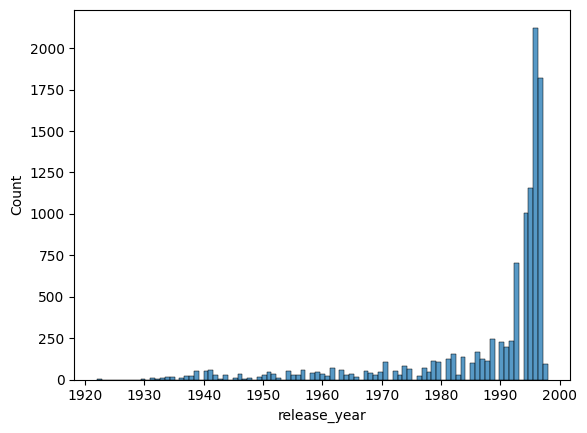

In [35]:
# Graficamos la frecuencia según año para recomendaciones de fin de semana
display(sns.histplot(data=X_test_3_sorted_wknd, x='release_year'))

<Axes: xlabel='release_year', ylabel='Count'>

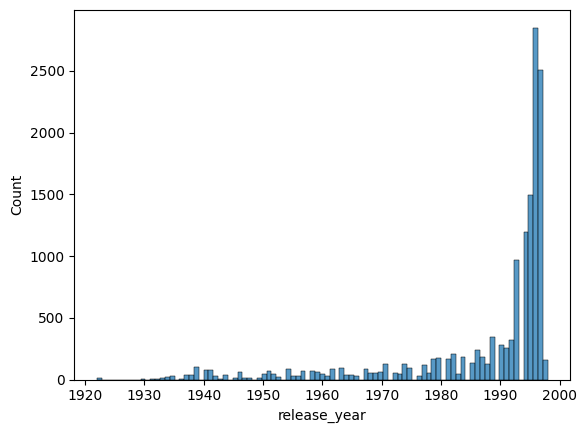

In [36]:
# Graficamos la frecuencia según año para recomendaciones de día de semana
display(sns.histplot(data=X_test_3_sorted_no_wknd, x='release_year'))

Podemos ver que nuestra hipótesis no se cumple. Es decir, las películas más recomendadas para un fin de semana son en su mayoría entre los 90 y 2000s, siguiendo una distribución similar para las películas recomendadas en un día de semana, las cuales también rondan en dicho rango. El supuesto que se realizó es que **dado que los adultos tienen menos tiempo en la semana, prefieren ver películas más en los fines de semana y por lo tanto dichas películas son más antiguas, dada la edad de un adulto**. Con este resultado podemos ver que el supuesto no es asumible y **refutar nuestra hipótesis**, ya que quizás un adulto de mayor edad no necesariamente prefiere ver películas mas antiguas, sino películas que estén de moda. Otro contraargumento podría ser que no necesariamente los adultos ven menos películas en la semana.



Se puede ver la distribución de años de lanzamiento para adultos mayores de 35 años.

<Axes: xlabel='release_year', ylabel='Count'>

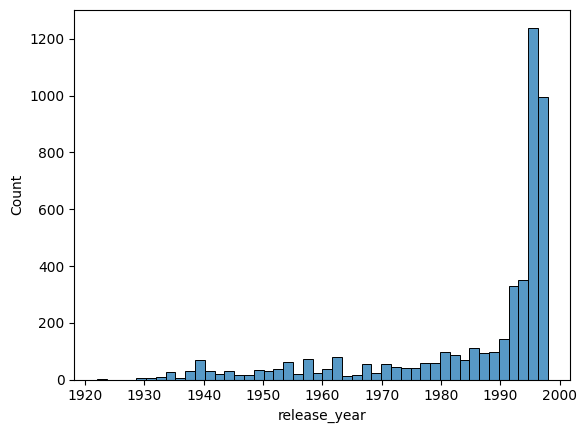

In [37]:
display(sns.histplot(data=X_test_3[X_test_3.age >= 35], x='release_year'))

Vemos claramente que las personas mayores a 35 años prefieren aún películas entre los 90 y 2000s, lo que refuerza nuestra idea anterior.

Como sugerencia experimental para plantear una hipótesis sobre las recomendaciones, tendería a revisar en primer lugar la distribución de los datos contextuales y los datos de contenido que se utilizarán, fijado en alguna variable que se contenga en la hipótesis. En concreto, si queremos analizar un subgrupo de usuarios que cumplan cierta característica, analizaría la distribución a priori de cada una de las features que se utilizarán para la recomendación y vería si dichas features se "separan" según intervalos o valores fijados en dicho subgrupo de usuarios. Por ejemplo, si queremos analizar un subgrupo de usuarios estudiantes, observaría la distribución de las películas que los estudiantes ven por año. Consideraría si los estudiantes ven películas de forma uniforme durante la semana o si existe alguna tendencia en ver más películas un cierto día. Por otra parte, analizaría si existen diferencias entre los géneros que ven los estudiantes versus los géneros de películas que ven los usuarios no estudiantes.

En conclusión, es fundamental entender en primer lugar la distribución de los datos fijada a cierta variable de estudio, para luego poder entender o garantizar que cierta hipótesis pueda tener cierta relevancia estadística, y así detectar patrones o recomendaciones que tengan relevancia de forma empírica para los usuarios.